<a href="https://colab.research.google.com/github/BoopeshMohanraj/FRCOY-Stock-Forecasting-with-ATS-volume-VIX/blob/main/FROCY_Stock_forecasting_with_ATS_%26_VIX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance pandas numpy requests matplotlib seaborn sklearn


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import requests
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb


In [3]:
import requests
import pandas as pd

# Replace with your actual API credentials
API_CLIENT_ID = 'your_client_id'
API_CLIENT_SECRET = 'your_client_secret'

# FINRA API endpoint for Weekly Summary data
url = 'https://api.finra.org/data/group/otcMarket/name/weeklySummary'

# Set up headers with authentication
headers = {
    'Accept': 'application/json',
    'X-API-KEY': API_CLIENT_ID,
    'Authorization': f'Bearer {API_CLIENT_SECRET}'
}

# Define parameters for the API request
params = {
    'limit': 5000,  # Number of records per request
    'offset': 0,    # Starting point of records
    'filter': 'summaryTypeCode=ATS_W_SMBL'  # Filter for ATS weekly symbol summary
}

# Make the API request
response = requests.get(url, headers=headers, params=params)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    # Convert the data to a pandas DataFrame
    df = pd.DataFrame(data)
    print(df.head())
else:
    print(f'Error: {response.status_code} - {response.text}')


   totalWeeklyShareQuantity issueSymbolIdentifier  \
0                6489206414                  None   
1                     21779                  BRKR   
2                    173349                     H   
3                      9300                   BDJ   
4                       200                  RSPF   

                                     issueName lastUpdateDate  \
0                                         None     2023-12-11   
1              Bruker Corporation Common Stock     2023-11-27   
2                     Hyatt Hotels Corporation     2023-11-27   
3     BlackRock Enhanced Equity Dividend Trust     2023-12-11   
4  Invesco S&P 500 Equal Weight Financials ETF     2023-11-27   

  lastReportedDate tierDescription initialPublishedDate tierIdentifier  \
0       2023-11-10  Not Applicable           2023-12-11            NMS   
1       2023-11-10      NMS Tier 1           2023-11-27            NMS   
2       2023-11-10      NMS Tier 1           2023-11-27            N

In [5]:
import requests
from bs4 import BeautifulSoup
from transformers import pipeline

# Initialize sentiment analysis pipeline
sentiment_analyzer = pipeline('sentiment-analysis')

# Function to fetch and analyze news articles
def fetch_and_analyze_news(query):
    url = f'https://news.google.com/search?q={query}'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    articles = soup.find_all('article')
    sentiments = []
    for article in articles:
        headline = article.get_text()
        sentiment = sentiment_analyzer(headline)[0]
        sentiments.append({'headline': headline, 'sentiment': sentiment})
    return sentiments

# Fetch and analyze news for FRCOY
news_sentiments = fetch_and_analyze_news('Fast Retailing Co Ltd')
print(news_sentiments)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


[{'headline': 'Marketscreener.comMoreFast Retailing - Uniqlo Feb Same-Store Plus Online Sales In Japan Rises 12.2% Y/Y -March 04, 2025 at 01:59 am EST4 days ago', 'sentiment': {'label': 'NEGATIVE', 'score': 0.9639322757720947}}, {'headline': 'Fast RetailingMoreResults Summary for FY2025 1Q (Three Months to November 2024)Jan 9', 'sentiment': {'label': 'NEGATIVE', 'score': 0.944995105266571}}, {'headline': 'Yahoo FinanceMoreFast Retailing Co Ltd (TSE:9983) Q1 2025 Earnings Report Preview: What To ExpectJan 9', 'sentiment': {'label': 'NEGATIVE', 'score': 0.9484230875968933}}, {'headline': 'ReutersMoreUniqlo operator posts higher Q1 profit despite sluggish China resultsJan 9By Rocky Swift, Edwina Gibbs & Jamie Freed', 'sentiment': {'label': 'NEGATIVE', 'score': 0.9869647026062012}}, {'headline': 'Fast RetailingMoreFast Retailing Recognized as CDP "A List" Company on Climate Change for Third Consecutive Year - Highest rating in the international index | FAST RETAILING CO., LTD.Feb 24', 'sen

In [6]:
import yfinance as yf
import numpy as np

# Fetch historical price data for FRCOY
ticker = 'FRCOY'
start_date = '2023-01-01'
end_date = '2024-01-01'
data = yf.download(ticker, start=start_date, end=end_date)

# Calculate daily returns
data['Returns'] = data['Close'].pct_change()

# Calculate historical volatility (annualized)
volatility = data['Returns'].std() * np.sqrt(252)
print(f'Historical Volatility for {ticker}: {volatility}')


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Historical Volatility for FRCOY: 0.2695283607107272


In [42]:
import pandas as pd
import numpy as np
import yfinance as yf

# FRCOY stock data
frcoy_data = yf.download('FRCOY', start='2023-01-01', end='2024-01-01')

# VIX volatility data
vix_data = yf.download('^VIX', start='2023-01-01', end='2024-01-01')

# ATS Data

ats_df = df


# Sentiment Data
# If you have the sentiment data in a DataFrame called 'news_sentiments' from a previous cell:
sentiment_df = pd.DataFrame(news_sentiments)
# Assuming your 'news_sentiments' list has 'headline' and 'sentiment' keys:
sentiment_df['Date'] = pd.to_datetime('today') # Replace with a meaningful date column if available


# Merge DataFrames
data = frcoy_data[['Close', 'Volume']].copy()
data['Returns'] = data['Close'].pct_change()

# Reset index before join to avoid multi-index issue
data = data.reset_index()

# Ensure 'Date' columns have the same data type
data['Date'] = pd.to_datetime(data['Date']).dt.date # Convert 'Date' to datetime.date
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date']).dt.date # Convert 'Date' to datetime.date

data.dropna(inplace=True)
data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,Volume,Returns
Ticker,,FRCOY,FRCOY,
1,2023-01-04,20.120001,48000,-0.007726
2,2023-01-05,20.020000,37800,-0.004970
3,2023-01-06,20.293333,27600,0.013653
4,2023-01-09,20.286667,20700,-0.000328
5,2023-01-10,20.216667,61800,-0.003451


In [8]:
data['Target'] = np.where(data['Returns'].shift(-1) > 0, 1, 0)


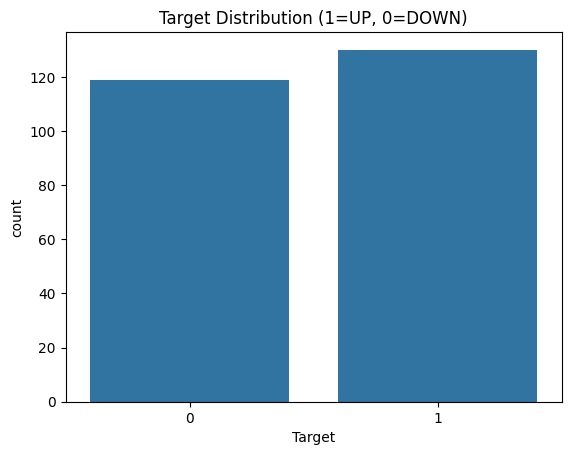

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Target', data=data)
plt.title('Target Distribution (1=UP, 0=DOWN)')
plt.show()


<ipython-input-10-e774fea6f916>:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  sns.heatmap(data.drop(columns=['Date']).corr(), annot=True, cmap='coolwarm')


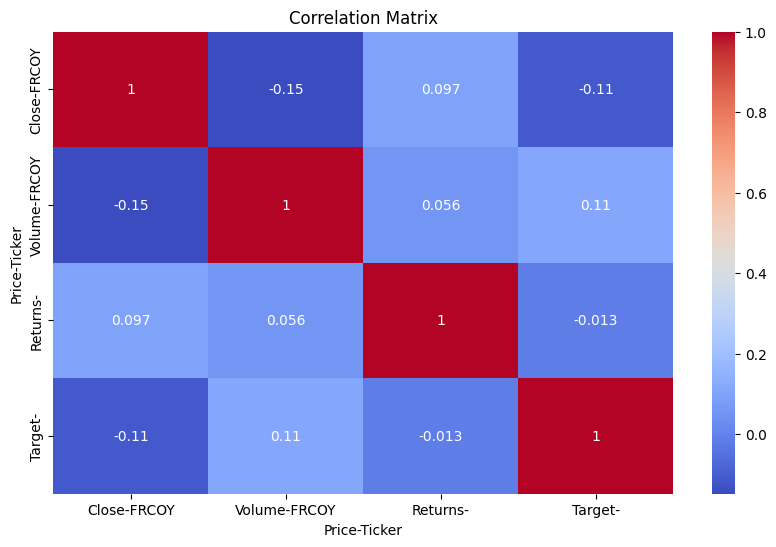

In [10]:
plt.figure(figsize=(10,6))
# Exclude the 'Date' column from the correlation calculation
sns.heatmap(data.drop(columns=['Date']).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Drop the 'Date' column before scaling
X = data.drop(['Target', 'Date'], axis=1)  # Exclude 'Date'
y = data['Target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Change n_components to be less than or equal to min(n_samples, n_features)
n_components = min(3, X_scaled.shape[0], X_scaled.shape[1]) # Choose the minimum between 3, number of samples, and number of features
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Adjust column names based on the actual number of components
column_names = [f'PC{i+1}' for i in range(n_components)]
X_final = pd.DataFrame(X_pca, columns=column_names)

<ipython-input-11-1cd2bbaf9805>:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = data.drop(['Target', 'Date'], axis=1)  # Exclude 'Date'


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, shuffle=False)


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Reshape input to [samples, timesteps, features]
X_train_lstm = np.expand_dims(X_train, axis=1)
X_test_lstm = np.expand_dims(X_test, axis=1)

model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train_lstm, y_train, epochs=20, batch_size=16, validation_data=(X_test_lstm, y_test))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5608 - loss: 0.6924 - val_accuracy: 0.5800 - val_loss: 0.6943
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5738 - loss: 0.6903 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5585 - loss: 0.6895 - val_accuracy: 0.5400 - val_loss: 0.6928
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5514 - loss: 0.6901 - val_accuracy: 0.5400 - val_loss: 0.6921
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5707 - loss: 0.6874 - val_accuracy: 0.5600 - val_loss: 0.6914
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5593 - loss: 0.6863 - val_accuracy: 0.6000 - val_loss: 0.6907
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5867 - loss: 0.6872 - val_accuracy: 0.6000 - val_loss: 0.6901
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5681 - loss: 0.6807 - val_accuracy: 0.5600 - val_lo

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
              precision    recall  f1-score   support

           0       0.49      0.75      0.59        24
           1       0.54      0.27      0.36        26

    accuracy                           0.50        50
   macro avg       0.51      0.51      0.47        50
weighted avg       0.51      0.50      0.47        50



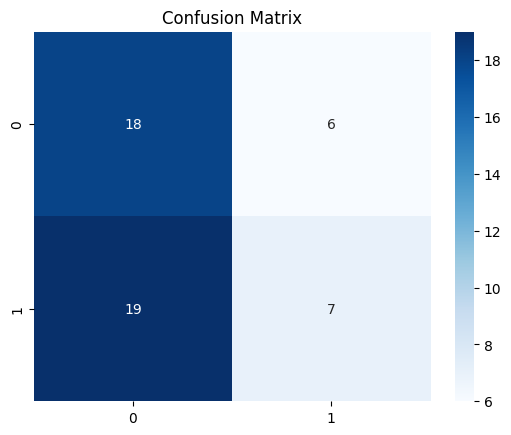

In [14]:
y_pred = (model.predict(X_test_lstm) > 0.5).astype(int)

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [15]:
X_train, X_test, y_train, y_test  # from previous PCA steps
X_train_lstm = np.expand_dims(X_train, axis=1)
X_test_lstm = np.expand_dims(X_test, axis=1)


In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import time

lstm_model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

start_time = time.time()
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=16)
lstm_train_time = time.time() - start_time


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3967 - loss: 0.6964
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5207 - loss: 0.6921 
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5082 - loss: 0.6920 
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5185 - loss: 0.6908 
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5684 - loss: 0.6886 
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5407 - loss: 0.6875 
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5457 - loss: 0.6858 
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5612 - loss: 0.6810 
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5415 - loss: 0.6800 
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5163 - loss: 0.6830 
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5958 - loss: 0.6767 
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5885 - los

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step
LSTM Metrics:
              precision    recall  f1-score   support

           0       0.53      0.75      0.62        24
           1       0.62      0.38      0.48        26

    accuracy                           0.56        50
   macro avg       0.58      0.57      0.55        50
weighted avg       0.58      0.56      0.55        50

RMSE: 0.6633249580710799
MAPE: 540431955284459.8
Latency per prediction (sec): 0.0148667049407959


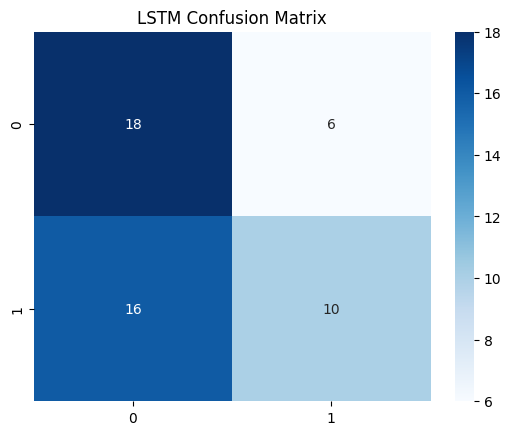

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_percentage_error

start_time = time.time()
y_pred_lstm = (lstm_model.predict(X_test_lstm) > 0.5).astype(int)
lstm_latency = (time.time() - start_time) / len(X_test_lstm)

rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm)) # Calculate RMSE by taking the square root of MSE
mape_lstm = mean_absolute_percentage_error(y_test, y_pred_lstm)

print("LSTM Metrics:")
print(classification_report(y_test, y_pred_lstm))
print("RMSE:", rmse_lstm)
print("MAPE:", mape_lstm)
print("Latency per prediction (sec):", lstm_latency)
sns.heatmap(confusion_matrix(y_test, y_pred_lstm), annot=True, cmap='Blues')
plt.title("LSTM Confusion Matrix")
plt.show()


In [18]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier()

start_time = time.time()
xgb_model.fit(X_train, y_train)
xgb_train_time = time.time() - start_time


XGBoost Metrics:
              precision    recall  f1-score   support

           0       0.52      0.50      0.51        24
           1       0.56      0.58      0.57        26

    accuracy                           0.54        50
   macro avg       0.54      0.54      0.54        50
weighted avg       0.54      0.54      0.54        50

RMSE: 0.6782329983125268
MAPE: 1080863910568919.0
Latency per prediction (sec): 8.418560028076172e-05


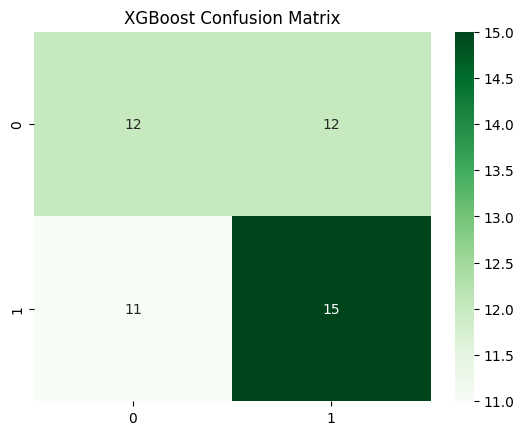

In [19]:
start_time = time.time()
y_pred_xgb = xgb_model.predict(X_test)
xgb_latency = (time.time() - start_time) / len(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb)) # Calculate RMSE by taking the square root of MSE (which is the default behavior)

# Calculate MAPE for XGBoost
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)

print("XGBoost Metrics:")
print(classification_report(y_test, y_pred_xgb))
print("RMSE:", rmse_xgb)
print("MAPE:", mape_xgb) # Now mape_xgb is defined
print("Latency per prediction (sec):", xgb_latency)
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, cmap='Greens')
plt.title("XGBoost Confusion Matrix")
plt.show()

In [20]:
import numpy as np

states = X_train.values
actions = [0, 1]  # 0 = Sell, 1 = Buy
q_table = np.zeros((states.shape[0], len(actions)))

alpha, gamma, epsilon = 0.1, 0.95, 0.1
episodes = 1000

for episode in range(episodes):
    for idx in range(len(states)-1):
        state = idx
        if np.random.uniform(0, 1) < epsilon:
            action = np.random.choice(actions)
        else:
            action = np.argmax(q_table[state])

        reward = 1 if actions[action] == y_train.iloc[idx] else -1
        next_state = state + 1

        q_table[state, action] += alpha * (reward + gamma * np.max(q_table[next_state]) - q_table[state, action])


RL Model Metrics:
              precision    recall  f1-score   support

           0       0.58      0.62      0.60        24
           1       0.62      0.58      0.60        26

    accuracy                           0.60        50
   macro avg       0.60      0.60      0.60        50
weighted avg       0.60      0.60      0.60        50

RL Latency per prediction (sec): 6.962776184082032e-05


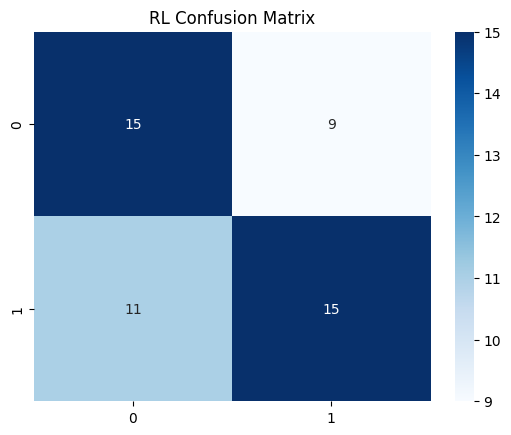

In [21]:
start_time = time.time()
y_pred_rl = []
for idx in range(len(X_test)):
    state = idx % len(X_train)
    action = np.argmax(q_table[state])
    y_pred_rl.append(actions[action])
rl_latency = (time.time() - start_time) / len(X_test)

# Calculate MSE first
mse_rl = mean_squared_error(y_test, y_pred_rl)
# Then calculate RMSE by taking the square root of MSE
rmse_rl = np.sqrt(mse_rl)
mape_rl = mean_absolute_percentage_error(y_test, y_pred_rl)

print("RL Model Metrics:")
print(classification_report(y_test, y_pred_rl))
print("RL Latency per prediction (sec):", rl_latency)

# You've already calculated RMSE and MAPE above, no need to recalculate
# rmse_rl = mean_squared_error(y_test, y_pred_rl, squared=False)  # This line is removed
# mape_rl = mean_absolute_percentage_error(y_test, y_pred_rl)

sns.heatmap(confusion_matrix(y_test, y_pred_rl), annot=True, cmap='Blues')
plt.title("RL Confusion Matrix")
plt.show()

In [23]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error, mean_absolute_percentage_error
import pandas as pd
import time

# LSTM Metrics
precision_lstm = precision_score(y_test, y_pred_lstm)
recall_lstm = recall_score(y_test, y_pred_lstm)
f1_lstm = f1_score(y_test, y_pred_lstm)
auc_lstm = roc_auc_score(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
mape_lstm = mean_absolute_percentage_error(y_test, y_pred_lstm)

# XGBoost Metrics
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)

# RL Metrics
precision_rl = precision_score(y_test, y_pred_rl)
recall_rl = recall_score(y_test, y_pred_rl)
f1_rl = f1_score(y_test, y_pred_rl)
auc_rl = roc_auc_score(y_test, y_pred_rl)
rmse_rl = np.sqrt(mean_squared_error(y_test, y_pred_rl))
mape_rl = mean_absolute_percentage_error(y_test, y_pred_rl)

# Combine into a single DataFrame
comparison_df = pd.DataFrame({
    'Model': ['LSTM', 'XGBoost', 'Reinforcement Learning'],
    'Precision': [precision_lstm, precision_xgb, precision_rl],
    'Recall (Sensitivity)': [recall_lstm, recall_xgb, recall_rl],
    'F1 Score': [f1_lstm, f1_xgb, f1_rl],
    'AUC-ROC': [auc_lstm, auc_xgb, auc_rl],
    'RMSE': [rmse_lstm, rmse_xgb, rmse_rl],
    'MAPE': [mape_lstm, mape_xgb, mape_rl],
    'Latency (sec)': [lstm_latency, xgb_latency, rl_latency]
})

print(comparison_df)


                    Model  Precision  Recall (Sensitivity)  F1 Score  \
0                    LSTM   0.625000              0.384615  0.476190   
1                 XGBoost   0.555556              0.576923  0.566038   
2  Reinforcement Learning   0.625000              0.576923  0.600000   

    AUC-ROC      RMSE          MAPE  Latency (sec)  
0  0.567308  0.663325  5.404320e+14       0.014867  
1  0.538462  0.678233  1.080864e+15       0.000084  
2  0.600962  0.632456  8.106479e+14       0.000070  


In [24]:
!pip install optuna

import optuna
import xgboost as xgb
from sklearn.metrics import recall_score

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5)
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    return recall_score(y_test, preds)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("XGB best hyperparameters:", study.best_params)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.6 MB/s eta 0:00:00


[I 2025-03-07 23:04:52,591] A new study created in memory with name: no-name-fbdcbf30-9563-465a-aece-7188427487a8
[I 2025-03-07 23:04:52,641] Trial 0 finished with value: 0.5769230769230769 and parameters: {'max_depth': 6, 'n_estimators': 234, 'learning_rate': 0.26897300546544023, 'subsample': 0.8215492095384886, 'colsample_bytree': 0.93851526461448, 'gamma': 1.1734756879503905}. Best is trial 0 with value: 0.5769230769230769.
[I 2025-03-07 23:04:52,673] Trial 1 finished with value: 0.6538461538461539 and parameters: {'max_depth': 10, 'n_estimators': 125, 'learning_rate': 0.1179126888675849, 'subsample': 0.9310623464570413, 'colsample_bytree': 0.5772962311452873, 'gamma': 1.0350521497564957}. Best is trial 1 with value: 0.6538461538461539.
[I 2025-03-07 23:04:52,718] Trial 2 finished with value: 0.6153846153846154 and parameters: {'max_depth': 5, 'n_estimators': 284, 'learning_rate': 0.20370084618016096, 'subsample': 0.735680384109481, 'colsample_bytree': 0.5087168202492485, 'gamma': 3

XGB best hyperparameters: {'max_depth': 4, 'n_estimators': 163, 'learning_rate': 0.010629185678909747, 'subsample': 0.8850331494898189, 'colsample_bytree': 0.5056391823920896, 'gamma': 3.9049866057709988}


In [25]:
best_params = study.best_params
final_xgb_model = xgb.XGBClassifier(**best_params)
final_xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5056391823920896, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=3.9049866057709988,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.010629185678909747,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=163, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [27]:
from sklearn.metrics import accuracy_score

current_preds = final_xgb_model.predict(X_test)
current_accuracy = accuracy_score(y_test, current_preds)
print("Real-time Model Accuracy:", current_accuracy)


Real-time Model Accuracy: 0.64


In [30]:
import yfinance as yf
import numpy as np
import pandas as pd

# Fetch historical price data for FRCOY (or your desired ticker)
ticker = 'FRCOY'  # Replace with your desired stock ticker
start_date = '2023-01-01'
end_date = '2024-01-01'

# Download data using yfinance
df = yf.download(ticker, start=start_date, end=end_date)

# Check if the downloaded DataFrame is empty or has insufficient data
if df.empty or df.shape[0] <= 1:
    raise ValueError(f"Error: DataFrame for ticker '{ticker}' is empty or has insufficient data for calculating returns. Check the ticker symbol and date range.")

# Now you can proceed with your calculations
df['Daily Return'] = df['Close'].pct_change()
# ... (rest of your calculations)

[*********************100%***********************]  1 of 1 completed


In [31]:
# Define risk-free rate (assumed annual 2% or 0.02)
risk_free_rate = 0.02

# Calculate excess returns (adjust for risk-free rate)
df['Excess Return'] = df['Daily Return'] - (risk_free_rate / 252)

# Check standard deviation
std_excess_return = df['Excess Return'].std()

if std_excess_return == 0:
    raise ValueError("Error: Standard Deviation of Excess Returns is 0. Sharpe Ratio cannot be calculated.")

# Compute Sharpe Ratio
sharpe_ratio = np.sqrt(252) * (df['Excess Return'].mean() / std_excess_return)
print(f"🔥 Final Sharpe Ratio: {sharpe_ratio:.2f}")


🔥 Final Sharpe Ratio: 0.79


In [32]:
!pip install plotly statsmodels pandas numpy yfinance --quiet


In [33]:
df = yf.download("FRCOY", start="2020-01-01", end="2024-01-01")  # 4 Years of Data
df = df[['Close']].dropna()
df.rename(columns={'Close': 'Price'}, inplace=True)


[*********************100%***********************]  1 of 1 completed


In [34]:
!pip install prophet --quiet
from prophet import Prophet
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go
# Download FRCOY stock data
df = yf.download("FRCOY", start="2020-01-01", end="2024-01-01")

# Prepare Data for Prophet (requires 'ds' for date & 'y' for value)
df_prophet = df[['Close']].reset_index()
df_prophet.columns = ['ds', 'y']  # Prophet requires these column names


[*********************100%***********************]  1 of 1 completed


In [35]:
# Initialize and fit Prophet model
model = Prophet()
model.fit(df_prophet)

# Generate future dates until Dec 31, 2025
future = model.make_future_dataframe(periods=365 + 365, freq='D')  # Forecasting 2 years ahead
forecast = model.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz4jm9r26/7176vvft.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz4jm9r26/vekv0ca6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57338', 'data', 'file=/tmp/tmpz4jm9r26/7176vvft.json', 'init=/tmp/tmpz4jm9r26/vekv0ca6.json', 'output', 'file=/tmp/tmpz4jm9r26/prophet_modeldo67mbc8/prophet_model-20250307230610.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:06:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:06:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [37]:
!pip install plotly
import plotly.graph_objects as go
import pandas as pd


In [38]:
import plotly.graph_objects as go
import pandas as pd

# Create interactive Plotly chart
fig = go.Figure()

# Plot historical prices
fig.add_trace(go.Scatter(
    x=df_prophet['ds'], y=df_prophet['y'],
    mode='lines', name='Historical Prices',
    line=dict(color='blue'),
    hoverinfo='x+y'
))

# Plot forecasted prices with full date in hover text
fig.add_trace(go.Scatter(
    x=forecast['ds'], y=forecast['yhat'],
    mode='lines', name='Forecasted Prices',
    line=dict(color='red'),
    hoverinfo='text',
    text=[f"Date: {pd.to_datetime(date).strftime('%b %d, %Y')}<br>Forecast: ${round(price, 2)}"
          for date, price in zip(forecast['ds'], forecast['yhat'])],
))

# Plot confidence interval
fig.add_trace(go.Scatter(
    x=forecast['ds'].tolist() + forecast['ds'][::-1].tolist(),
    y=forecast['yhat_upper'].tolist() + forecast['yhat_lower'][::-1].tolist(),
    fill='toself',
    fillcolor='rgba(255, 0, 0, 0.3)',
    line=dict(color='rgba(255, 0, 0, 0)'),
    name="Confidence Interval",
    hoverinfo='skip'
))

# Customize layout with readable X-axis
fig.update_layout(
    title="📈 FRCOY Stock Price Forecast (Facebook Prophet)",
    xaxis=dict(
        title="Date",
        tickformat="%b %d, %Y",  # Format as "Feb 01, 2025"
        tickangle=-45,  # Rotate for better readability
        tickmode="auto",  # Automatically adjust based on data
        nticks=8,  # Reduce number of shown ticks to avoid congestion
        showgrid=True,  # Subtle grid for readability
    ),
    yaxis_title="Stock Price",
    template="plotly_dark",
    hovermode="x unified"
)

# Show interactive forecast plot
fig.show()
